In [1]:
import numpy as np
import pandas as pd
import pickle
import soundfile as sf
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import glob
import time
import warnings
from VGGish.vggish_input import waveform_to_examples, wavfile_to_examples
np.random.seed(42)

In [2]:
TRAIN_SIZE = 0.75
VAL_SIZE = 0.1
spectrogram_folder = os.path.join('.','Spectrograms')

In [3]:
labels_df = pd.read_excel('BhajanLabels.xlsx')
labels_df.set_index('File Name', inplace=True)
# labels_df = labels_df[labels_df['Comment'].isnull()]
# singer_map = pd.Series(labels_df.Artist.values, index = labels_df['Old Name'].values +'.wav').to_dict()

In [4]:
def is_train_val_test(train_size, val_size):
    """Outputs either train, val or test based probabilites provided"""
    
    if (train_size + val_size) >= 1 :
        raise ValueError('Sum of train and validation size must be less than 1')
    choices = ['train','test','val']
    out = np.random.choice(choices,1,p=[train_size, val_size, 1 - (train_size + val_size)])[0]
    return out

In [5]:
def get_time_segments(input_string,min_sample_size=4):
    """
    Input string is of format "start - end; start - end;" and so on
    Output is a list of [[start,end],[start,end]]
    Keep a tuple in output only if [end-start]>min_sample_size
    """
    
    segments = []
    if not pd.isnull(input_string): 
        for duration in input_string.split(';'):
            timestamps = duration.split('-')
            if len(timestamps)==2:
                try:
                    s = float(timestamps[0])
                    e = float(timestamps[1])
                    if (e-s)>min_sample_size:
                        segments.append([s,e])
                except ValueError:
                    # Ignore and continue
                    pass
    return segments

In [17]:
def save_audio(out_file,data,samplerate,label,return_spectrograms=False):
    """"
    By default don't return spectrograms (spectrogram configuration is specified in vggish_params)
    Save file only if it doesn't exist already
    """
    try:
        if not os.path.isfile(out_file):
            sf.write(out_file,data,samplerate)
        spectrograms = waveform_to_examples(data, samplerate)
        save_spectrogram_as_npy(out_file, spectrograms)
        if return_spectrograms:
            return spectrograms
    except:
        print(out_file + " failed.")

In [7]:
def save_spectrograms(file_path, spectrograms):
    """
    Save spectrograms to file_path
    If file already exists, append spectrograms to the file and save
    """
    
    existing_spectrograms = np.array([])
    if os.path.isfile(file_path):
        existing_spectrograms = np.load(file_path)
    np.save(file_path,concatenate([spectrograms, existing_spectrograms]))

In [8]:
def save_spectrogram_as_pkl(file_path, spectrograms, label):
    """
    Save spectrograms in the format
    {
        'data':spectrograms,
        'label':label
    }
    If file exists, do nothing
    spectrogram must be numpy array or list
    """
    
    if not isinstance(spectrograms, np.ndarray) and not isinstance(spectrograms, list):
        raise TypeError('Must be numpy array or list')
    if not os.path.isfile(file_path):
        output = {
            'data':spectrograms.tolist() if isinstance(spectrograms, np.ndarray) else spectrograms,
            'label':label
        }
        with open(file_path, 'wb') as f:
            pickle.dump(output, f)

In [9]:
def save_spectrogram_as_npy(file_path,spectrogram):
    """Spectrogram is a three dimensional np array with the last two dimensions storing the individual spectrogam"""
    
    if spectrogram.ndim != 3:
        raise ValueError('Expected 3 dimension, got' + str(spectrogram.ndim))
    file_name = os.path.basename(file_path).split('.')[0] # ./abc/asdf/test.wav returns test
    dir_name = os.path.dirname(file_path) # ./abc/asdf/test.wav return ./abc/asdf
    artist_name = os.path.basename(dir_name)
    for i in range(spectrogram.shape[0]):
        out_file = file_name + '_Part_' + str(i) + '.npy'
        train_test_val = is_train_val_test(TRAIN_SIZE,VAL_SIZE)
        out_path = os.path.join(spectrogram_folder,train_test_val,artist_name,out_file)
        if not os.path.exists(os.path.dirname(out_path)):
            os.makedirs(os.path.dirname(out_path))
        np.save(out_path,spectrogram[i,:])

In [10]:
def concatenate(ndarray):
    """Wrapper on top of numpy's concatenate that ignores empty numpy arrays in the input provided"""
    
    temp_array = []
    for item in ndarray:
        if not isinstance(item,np.ndarray):
            raise TypeError('All elements must be Numpy Arrays')
        if item.size>0:
            temp_array.append(item)
    if len(temp_array)==0:
        return np.array(temp_array)
    else:
        return np.concatenate(temp_array)

In [11]:
def segment_and_save(input_file_path, segments, out_folder_path):
    """
    Parameters
    ----------
    input_file_path - input audio file to be segmented and saved
    segments - a list of the format [[start_time, end_time],[..]]
    output_folder - destination for audio segments and corresponding spectrograms
    artist_name is inferred as the folder name of out_path_path
    """
    
    input_file_name = os.path.basename(input_file_path)[:-4]
    artist_name = os.path.basename(out_folder_path) 
    if os.path.isfile(os.path.join(out_folder_path,input_file_name+'_Segment_0.wav')):
        # If input file has been processed once before, don't load and segment again
        return
    if len(segments)==0:
        # If no segments provided for a file, don't load and segment
        return
    wav_data, sr = librosa.load(input_file_path)
    if not os.path.exists(out_folder_path):
        os.mkdir(out_folder_path)
    func_args = []
    for i,segment in enumerate(segments):
        start = int(segment[0]*sr)
        end = int(segment[1]*sr)
        out_file_path = os.path.join(out_folder_path,input_file_name+'_Segment_'+str(i)+'.wav')
        func_args.append((out_file_path,wav_data[start:end],sr,artist_name))
    with Pool(processes=len(func_args)) as pool:
        pool.starmap(save_audio,func_args)

In [18]:
in_data_folder = os.path.join('.','Data')
out_data_folder = os.path.join('.','SegmentedData')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    if not os.path.exists(out_data_folder):
        os.mkdir(out_data_folder)
    artists = os.listdir(in_data_folder)
    for artist in artists:
        artist_folder = os.path.join(in_data_folder,artist)
        out_folder = os.path.join(out_data_folder,artist)
        chorus_folder = os.path.join(out_data_folder,'Chorus')
        chorus_spectrograms = []
        if os.path.isdir(artist_folder):
            audio_files = os.listdir(artist_folder)
            audio_files = [file_name for file_name in audio_files if file_name != '.DS_Store']
            artist_spectrograms = []
            l = len(audio_files)
            for idx,audio_file in enumerate(audio_files):
                print(artist,idx+1,'/',l,end='\r')
                file_path = os.path.join(artist_folder,audio_file)
                if os.path.isfile(file_path) and (audio_file in labels_df.index):
                    lead_time_steps = get_time_segments(labels_df['Lead Segments'][audio_file])
                    chorus_time_steps = get_time_segments(labels_df['Chorus Segments'][audio_file])
                    segment_and_save(file_path,lead_time_steps,out_folder)
                    segment_and_save(file_path,chorus_time_steps,chorus_folder)
            print(artist,idx+1,'/',l)

Lakshminarayan 9 / 9
F18 1 / 1
F11 1 / 1
M Child2 2 / 2
F17 1 / 1
F10 1 / 1
F19 1 / 1
Arvind 11 / 11
M8 1 / 1
M1 4 / 4
M6 4 / 4
M7 1 / 1
M9 1 / 1
Avinash 79 / 79
F4 6 / 6
Dara 15 / 15
F Child1 8 / 8
M12 1 / 1
F2 8 / 8
F5 2 / 2
M14 1 / 1
M13 1 / 1
Nikita 2 / 2
Sangeetha 5 / 5
Sneha 1 / 1
M Child1 6 / 6
F15 1 / 1
F12 1 / 1
F13 1 / 1
F14 2 / 2
M5 1 / 1
M2 14 / 14
Krishna 48 / 48
M3 3 / 3
M4 1 / 1
./SegmentedData/Chorus/Record-134_Segment_13.wav failed.
./SegmentedData/Chorus/Record-043_Segment_11.wav failed.
Rushi 45 / 45
Emma 3 / 3
Chorus 4 / 4
M11 1 / 1
F9 1 / 1
F7 3 / 3
M10 1 / 1
Tara 1 / 1
F6 1 / 1
F1 1 / 1
Aishwarya 1 / 1
F8 1 / 1
Kumar 19 / 19


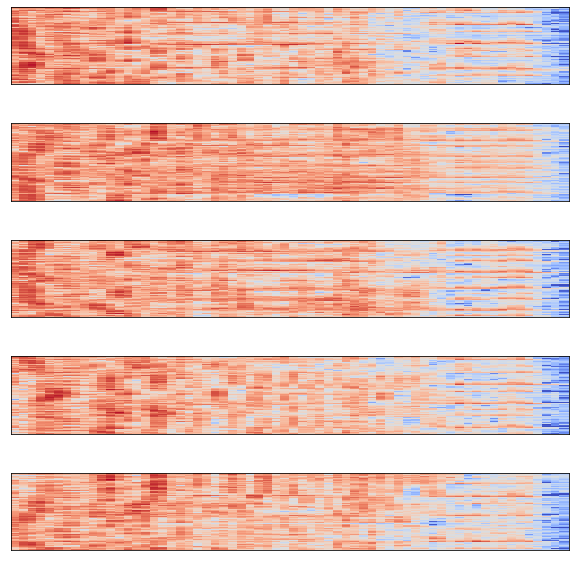

In [72]:
# Visualize random spectrograms of a given class
artist_name = 'Lakshminarayan'
spectrograms = np.load(os.path.join(out_data_folder,artist_name,artist_name+'.npy'))
num_of_specs_to_view = 5
indexes = np.random.choice(np.arange(spectrograms.shape[0]),num_of_specs_to_view, replace=False)
fig, axes = plt.subplots(num_of_specs_to_view,1)
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(10,10)
for idx, spec_index in enumerate(indexes):
    librosa.display.specshow(spectrograms[spec_index,:],ax=axes[idx])

In [3]:
from DataGenerator import ClassificationDataGenerator, FingerprintingDataGenerator
from keras.models import load_model
gen = FingerprintingDataGenerator(
    data_dir = './Spectrograms/val',
    sampling_mode='all',
    batch_size = 32,
    exclude_class='Chorus',
    n_threads=2
)
m = load_model('./TrainedModels/fingerprinting_128_v0.3.h5')
m.evaluate(gen)

  2/605 [..............................] - ETA: 1:02:14

Process ForkPoolWorker-237:
Traceback (most recent call last):
Process ForkPoolWorker-236:
  File "/Users/avinashn@us.ibm.com/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/avinashn@us.ibm.com/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/avinashn@us.ibm.com/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
Traceback (most recent call last):
  File "/Users/avinashn@us.ibm.com/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/Users/avinashn@us.ibm.com/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/avinashn@us.ibm.com/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/avinashn@us.ibm.com/anaconda3/lib/python

KeyboardInterrupt: 